## 1️⃣ Import Required Libraries

In [1]:
import os
import sys
import json
from pathlib import Path
import random
from typing import Dict, List, Tuple, Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
from tqdm.auto import tqdm

# PyTorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF

# Albumentations for advanced augmentation
import albumentations as A
from albumentations.pytorch import ToTensorV2

import warnings
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Set random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

print("✅ Libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

✅ Libraries imported successfully!
PyTorch version: 2.7.1+cu118
CUDA available: True
GPU: NVIDIA GeForce MX450


## 2️⃣ Setup Paths and Configuration

In [2]:
# Project paths
project_root = Path.cwd().parent
dataset_root = project_root / 'data' / 'zalando-hd-resized'
output_dir = project_root / 'data' / 'processed'
output_dir.mkdir(parents=True, exist_ok=True)

print(f"📁 Project Root: {project_root}")
print(f"📁 Dataset Root: {dataset_root}")
print(f"📁 Output Directory: {output_dir}")

# Configuration
config = {
    'image_size': (512, 384),  # (height, width) - can change to (1024, 768) for higher res
    'batch_size': 8,
    'num_workers': 4,
    'train_split': 0.9,  # 90% train, 10% validation from train set
    'mean': [0.5, 0.5, 0.5],  # ImageNet defaults
    'std': [0.5, 0.5, 0.5],
    'augmentation': True,
    'shuffle': True,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu'
}

print("\n⚙️ Configuration:")
for key, value in config.items():
    print(f"   {key}: {value}")

📁 Project Root: d:\Projects\AI-Virtual-TryOn
📁 Dataset Root: d:\Projects\AI-Virtual-TryOn\data\zalando-hd-resized
📁 Output Directory: d:\Projects\AI-Virtual-TryOn\data\processed

⚙️ Configuration:
   image_size: (512, 384)
   batch_size: 8
   num_workers: 4
   train_split: 0.9
   mean: [0.5, 0.5, 0.5]
   std: [0.5, 0.5, 0.5]
   augmentation: True
   shuffle: True
   device: cuda


## 3️⃣ Create Dataset Catalog

In [3]:
def create_dataset_catalog(dataset_root: Path, split: str = 'train') -> pd.DataFrame:
    """
    Create a catalog of all files in the dataset.
    
    Args:
        dataset_root: Root directory of dataset
        split: 'train' or 'test'
    
    Returns:
        DataFrame with file paths for each component
    """
    split_dir = dataset_root / split
    
    # Component directories
    image_dir = split_dir / 'image'
    cloth_dir = split_dir / 'cloth'
    parse_dir = split_dir / 'image-parse-v3'
    pose_img_dir = split_dir / 'openpose_img'
    pose_json_dir = split_dir / 'openpose_json'
    
    # Get all person images as base
    image_files = sorted(image_dir.glob('*.jpg'))
    
    catalog_data = []
    
    for img_path in tqdm(image_files, desc=f"Creating {split} catalog"):
        filename = img_path.stem
        
        # Find corresponding files
        cloth_path = cloth_dir / f"{filename}.jpg"
        parse_path = parse_dir / f"{filename}.png"
        pose_img_path = pose_img_dir / f"{filename}_rendered.png"
        pose_json_path = pose_json_dir / f"{filename}_keypoints.json"
        
        # Check all files exist
        if all([p.exists() for p in [cloth_path, parse_path, pose_json_path]]):
            catalog_data.append({
                'id': filename,
                'person_image': str(img_path),
                'cloth_image': str(cloth_path),
                'parse_mask': str(parse_path),
                'pose_image': str(pose_img_path) if pose_img_path.exists() else None,
                'pose_json': str(pose_json_path),
                'split': split
            })
    
    df = pd.DataFrame(catalog_data)
    print(f"\n✅ Created catalog for {split} split: {len(df)} samples")
    
    return df

# Create catalogs
print("="*70)
print("📋 CREATING DATASET CATALOGS")
print("="*70)

train_catalog = create_dataset_catalog(dataset_root, 'train')
test_catalog = create_dataset_catalog(dataset_root, 'test')

print(f"\n📊 Total samples:")
print(f"   Train: {len(train_catalog)}")
print(f"   Test: {len(test_catalog)}")
print("\n" + "="*70)

📋 CREATING DATASET CATALOGS


Creating train catalog:   0%|          | 0/11647 [00:00<?, ?it/s]


✅ Created catalog for train split: 11647 samples


Creating test catalog:   0%|          | 0/2032 [00:00<?, ?it/s]


✅ Created catalog for test split: 2032 samples

📊 Total samples:
   Train: 11647
   Test: 2032



## 4️⃣ Split Train into Train/Validation

In [4]:
# Shuffle and split
train_catalog = train_catalog.sample(frac=1, random_state=42).reset_index(drop=True)

split_idx = int(len(train_catalog) * config['train_split'])
train_df = train_catalog[:split_idx].copy()
val_df = train_catalog[split_idx:].copy()

train_df['split'] = 'train'
val_df['split'] = 'val'
test_df = test_catalog.copy()

print("="*70)
print("✂️ DATASET SPLITS")
print("="*70)
print(f"\n📊 Split sizes:")
print(f"   Training:   {len(train_df):5d} samples ({len(train_df)/len(train_catalog)*100:.1f}%)")
print(f"   Validation: {len(val_df):5d} samples ({len(val_df)/len(train_catalog)*100:.1f}%)")
print(f"   Test:       {len(test_df):5d} samples")
print(f"\n   Total:      {len(train_df) + len(val_df) + len(test_df):5d} samples")
print("\n" + "="*70)

# Save catalogs
train_df.to_csv(output_dir / 'train_catalog.csv', index=False)
val_df.to_csv(output_dir / 'val_catalog.csv', index=False)
test_df.to_csv(output_dir / 'test_catalog.csv', index=False)

print("\n✅ Catalogs saved to:", output_dir)

✂️ DATASET SPLITS

📊 Split sizes:
   Training:   10482 samples (90.0%)
   Validation:  1165 samples (10.0%)
   Test:        2032 samples

   Total:      13679 samples


✅ Catalogs saved to: d:\Projects\AI-Virtual-TryOn\data\processed


## 5️⃣ Define Preprocessing Transforms

In [5]:
def get_transforms(config: Dict, mode: str = 'train'):
    """
    Get image transformation pipeline using Albumentations.
    
    Args:
        config: Configuration dictionary
        mode: 'train', 'val', or 'test'
    
    Returns:
        Albumentations transform pipeline
    """
    height, width = config['image_size']
    
    if mode == 'train' and config['augmentation']:
        transform = A.Compose([
            # Resize
            A.Resize(height, width, interpolation=cv2.INTER_LINEAR),
            
            # Color augmentations
            A.ColorJitter(
                brightness=0.2,
                contrast=0.2,
                saturation=0.2,
                hue=0.1,
                p=0.5
            ),
            
            # Blur and noise
            A.OneOf([
                A.GaussianBlur(blur_limit=(3, 7), p=1.0),
                A.MedianBlur(blur_limit=5, p=1.0),
            ], p=0.3),
            
            # Normalization
            A.Normalize(
                mean=config['mean'],
                std=config['std'],
                max_pixel_value=255.0
            ),
            
            # Convert to tensor
            ToTensorV2()
        ])
    else:
        # Validation/Test transforms (no augmentation)
        transform = A.Compose([
            A.Resize(height, width, interpolation=cv2.INTER_LINEAR),
            A.Normalize(
                mean=config['mean'],
                std=config['std'],
                max_pixel_value=255.0
            ),
            ToTensorV2()
        ])
    
    return transform

# Create transforms
train_transform = get_transforms(config, mode='train')
val_transform = get_transforms(config, mode='val')
test_transform = get_transforms(config, mode='test')

print("✅ Transforms created:")
print(f"   Train: Augmentation={'ON' if config['augmentation'] else 'OFF'}")
print(f"   Val/Test: Augmentation=OFF")

✅ Transforms created:
   Train: Augmentation=ON
   Val/Test: Augmentation=OFF


## 6️⃣ Pose Keypoints Processing

In [6]:
def load_pose_keypoints(pose_json_path: str, original_size: Tuple[int, int] = (768, 1024), 
                       target_size: Tuple[int, int] = (384, 512)) -> np.ndarray:
    """
    Load and process OpenPose keypoints from JSON file.
    
    Args:
        pose_json_path: Path to pose JSON file
        original_size: Original image size (width, height)
        target_size: Target image size (width, height)
    
    Returns:
        Keypoints array of shape (25, 3) - [x, y, confidence]
    """
    with open(pose_json_path, 'r') as f:
        pose_data = json.load(f)
    
    if not pose_data['people']:
        # No person detected, return zeros
        return np.zeros((25, 3), dtype=np.float32)
    
    # Get first person's keypoints
    keypoints = pose_data['people'][0]['pose_keypoints_2d']
    keypoints = np.array(keypoints, dtype=np.float32).reshape(-1, 3)
    
    # Scale keypoints to target size
    orig_w, orig_h = original_size
    target_w, target_h = target_size
    
    keypoints[:, 0] = keypoints[:, 0] * (target_w / orig_w)  # Scale x
    keypoints[:, 1] = keypoints[:, 1] * (target_h / orig_h)  # Scale y
    
    return keypoints

def create_pose_map(keypoints: np.ndarray, image_size: Tuple[int, int]) -> np.ndarray:
    """
    Create a pose map from keypoints (useful for visualization or as input).
    
    Args:
        keypoints: Array of shape (25, 3)
        image_size: (height, width)
    
    Returns:
        Pose map of shape (height, width, 1)
    """
    height, width = image_size
    pose_map = np.zeros((height, width, 1), dtype=np.float32)
    
    # Draw keypoints
    for kpt in keypoints:
        x, y, conf = kpt
        if conf > 0.1:  # Only draw confident keypoints
            x, y = int(x), int(y)
            if 0 <= x < width and 0 <= y < height:
                cv2.circle(pose_map, (x, y), radius=3, color=1.0, thickness=-1)
    
    return pose_map

# Test pose loading
sample_json = train_df.iloc[0]['pose_json']
test_keypoints = load_pose_keypoints(
    sample_json, 
    original_size=(768, 1024),
    target_size=(config['image_size'][1], config['image_size'][0])  # (width, height)
)

print("✅ Pose processing functions created")
print(f"   Sample keypoints shape: {test_keypoints.shape}")
print(f"   Valid keypoints: {(test_keypoints[:, 2] > 0.1).sum()}/25")

✅ Pose processing functions created
   Sample keypoints shape: (25, 3)
   Valid keypoints: 14/25


## 7️⃣ Define PyTorch Dataset Class

In [7]:
class VITONDataset(Dataset):
    """
    PyTorch Dataset for VITON-HD data.
    
    Returns:
        Dictionary containing:
            - person_image: Person image tensor [3, H, W]
            - cloth_image: Garment image tensor [3, H, W]
            - parse_mask: Segmentation mask tensor [H, W]
            - pose_keypoints: Pose keypoints [25, 3]
            - pose_map: Pose map tensor [1, H, W]
            - id: Sample ID string
    """
    
    def __init__(self, catalog_df: pd.DataFrame, config: Dict, transform=None):
        """
        Args:
            catalog_df: DataFrame with file paths
            config: Configuration dictionary
            transform: Albumentations transform pipeline
        """
        self.catalog = catalog_df.reset_index(drop=True)
        self.config = config
        self.transform = transform
        
    def __len__(self):
        return len(self.catalog)
    
    def __getitem__(self, idx):
        row = self.catalog.iloc[idx]
        
        # Load images
        person_image = cv2.imread(row['person_image'])
        person_image = cv2.cvtColor(person_image, cv2.COLOR_BGR2RGB)
        
        cloth_image = cv2.imread(row['cloth_image'])
        cloth_image = cv2.cvtColor(cloth_image, cv2.COLOR_BGR2RGB)
        
        parse_mask = cv2.imread(row['parse_mask'], cv2.IMREAD_GRAYSCALE)
        
        # Load pose keypoints
        pose_keypoints = load_pose_keypoints(
            row['pose_json'],
            original_size=(768, 1024),
            target_size=(self.config['image_size'][1], self.config['image_size'][0])
        )
        
        # Apply transforms to images
        if self.transform:
            # Transform person image
            transformed = self.transform(image=person_image)
            person_tensor = transformed['image']
            
            # Transform cloth image
            transformed = self.transform(image=cloth_image)
            cloth_tensor = transformed['image']
            
            # Transform mask (no normalization)
            mask_transform = A.Compose([
                A.Resize(
                    self.config['image_size'][0],
                    self.config['image_size'][1],
                    interpolation=cv2.INTER_NEAREST
                ),
            ])
            transformed = mask_transform(image=parse_mask)
            mask_tensor = torch.from_numpy(transformed['image']).long()
        else:
            # No transform, just resize and convert to tensor
            person_tensor = torch.from_numpy(person_image).permute(2, 0, 1).float() / 255.0
            cloth_tensor = torch.from_numpy(cloth_image).permute(2, 0, 1).float() / 255.0
            mask_tensor = torch.from_numpy(parse_mask).long()
        
        # Create pose map
        pose_map = create_pose_map(pose_keypoints, self.config['image_size'])
        pose_map_tensor = torch.from_numpy(pose_map).permute(2, 0, 1).float()
        
        # Convert keypoints to tensor
        pose_keypoints_tensor = torch.from_numpy(pose_keypoints).float()
        
        return {
            'person_image': person_tensor,
            'cloth_image': cloth_tensor,
            'parse_mask': mask_tensor,
            'pose_keypoints': pose_keypoints_tensor,
            'pose_map': pose_map_tensor,
            'id': row['id']
        }

print("✅ VITONDataset class defined")

✅ VITONDataset class defined


## 8️⃣ Create DataLoaders

In [8]:
# Create datasets
train_dataset = VITONDataset(train_df, config, transform=train_transform)
val_dataset = VITONDataset(val_df, config, transform=val_transform)
test_dataset = VITONDataset(test_df, config, transform=test_transform)

# Create dataloaders
train_loader = DataLoader(
    train_dataset,
    batch_size=config['batch_size'],
    shuffle=config['shuffle'],
    num_workers=config['num_workers'],
    pin_memory=True if config['device'] == 'cuda' else False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=config['batch_size'],
    shuffle=False,
    num_workers=config['num_workers'],
    pin_memory=True if config['device'] == 'cuda' else False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=config['batch_size'],
    shuffle=False,
    num_workers=config['num_workers'],
    pin_memory=True if config['device'] == 'cuda' else False
)

print("="*70)
print("🔄 DATALOADERS CREATED")
print("="*70)
print(f"\n📊 DataLoader Statistics:")
print(f"   Train:")
print(f"      - Samples: {len(train_dataset)}")
print(f"      - Batches: {len(train_loader)}")
print(f"      - Batch size: {config['batch_size']}")
print(f"      - Shuffle: {config['shuffle']}")
print(f"\n   Validation:")
print(f"      - Samples: {len(val_dataset)}")
print(f"      - Batches: {len(val_loader)}")
print(f"\n   Test:")
print(f"      - Samples: {len(test_dataset)}")
print(f"      - Batches: {len(test_loader)}")
print(f"\n   Workers: {config['num_workers']}")
print(f"   Device: {config['device']}")
print("\n" + "="*70)

🔄 DATALOADERS CREATED

📊 DataLoader Statistics:
   Train:
      - Samples: 10482
      - Batches: 1311
      - Batch size: 8
      - Shuffle: True

   Validation:
      - Samples: 1165
      - Batches: 146

   Test:
      - Samples: 2032
      - Batches: 254

   Workers: 4
   Device: cuda



## 9️⃣ Test DataLoader - Load Sample Batch

In [9]:
# Windows multiprocessing issue - test with num_workers=0 first
print("🔍 Testing DataLoader (Windows-compatible mode)...\n")
print("⚠️ Note: Using num_workers=0 to avoid Windows multiprocessing issues\n")

# Create a test loader with num_workers=0 for Windows compatibility
test_loader_single = DataLoader(
    train_dataset,
    batch_size=config['batch_size'],
    shuffle=False,
    num_workers=0,  # No multiprocessing - works reliably on Windows
    pin_memory=True if config['device'] == 'cuda' else False
)

# Load a few batches with progress bar
n_test_batches = 3
sample_batch = None

print(f"📦 Loading {n_test_batches} batches to verify pipeline...")
for i, batch in enumerate(tqdm(test_loader_single, total=n_test_batches, desc="Loading batches")):
    sample_batch = batch
    if i >= n_test_batches - 1:
        break

print("\n" + "="*70)
print("📦 SAMPLE BATCH CONTENTS")
print("="*70)

for key, value in sample_batch.items():
    if isinstance(value, torch.Tensor):
        print(f"\n{key}:")
        print(f"   Shape: {value.shape}")
        print(f"   Dtype: {value.dtype}")
        print(f"   Device: {value.device}")
        if value.dtype in [torch.float32, torch.float64]:
            print(f"   Range: [{value.min().item():.3f}, {value.max().item():.3f}]")
    else:
        print(f"\n{key}:")
        print(f"   Type: {type(value)}")
        print(f"   Length: {len(value)}")

print("\n" + "="*70)
print(f"\n✅ Successfully loaded {n_test_batches} batches!")
print("\n💡 TIP: On Windows, use num_workers=0 in DataLoaders to avoid hanging issues.")

🔍 Testing DataLoader (Windows-compatible mode)...

⚠️ Note: Using num_workers=0 to avoid Windows multiprocessing issues

📦 Loading 3 batches to verify pipeline...


Loading batches:   0%|          | 0/3 [00:00<?, ?it/s]


📦 SAMPLE BATCH CONTENTS

person_image:
   Shape: torch.Size([8, 3, 512, 384])
   Dtype: torch.float32
   Device: cpu
   Range: [-1.000, 1.000]

cloth_image:
   Shape: torch.Size([8, 3, 512, 384])
   Dtype: torch.float32
   Device: cpu
   Range: [-1.000, 1.000]

parse_mask:
   Shape: torch.Size([8, 512, 384])
   Dtype: torch.int64
   Device: cpu

pose_keypoints:
   Shape: torch.Size([8, 25, 3])
   Dtype: torch.float32
   Device: cpu
   Range: [0.000, 503.260]

pose_map:
   Shape: torch.Size([8, 1, 512, 384])
   Dtype: torch.float32
   Device: cpu
   Range: [0.000, 1.000]

id:
   Type: <class 'list'>
   Length: 8


✅ Successfully loaded 3 batches!

💡 TIP: On Windows, use num_workers=0 in DataLoaders to avoid hanging issues.


## 🔟 Visualize Sample Batch

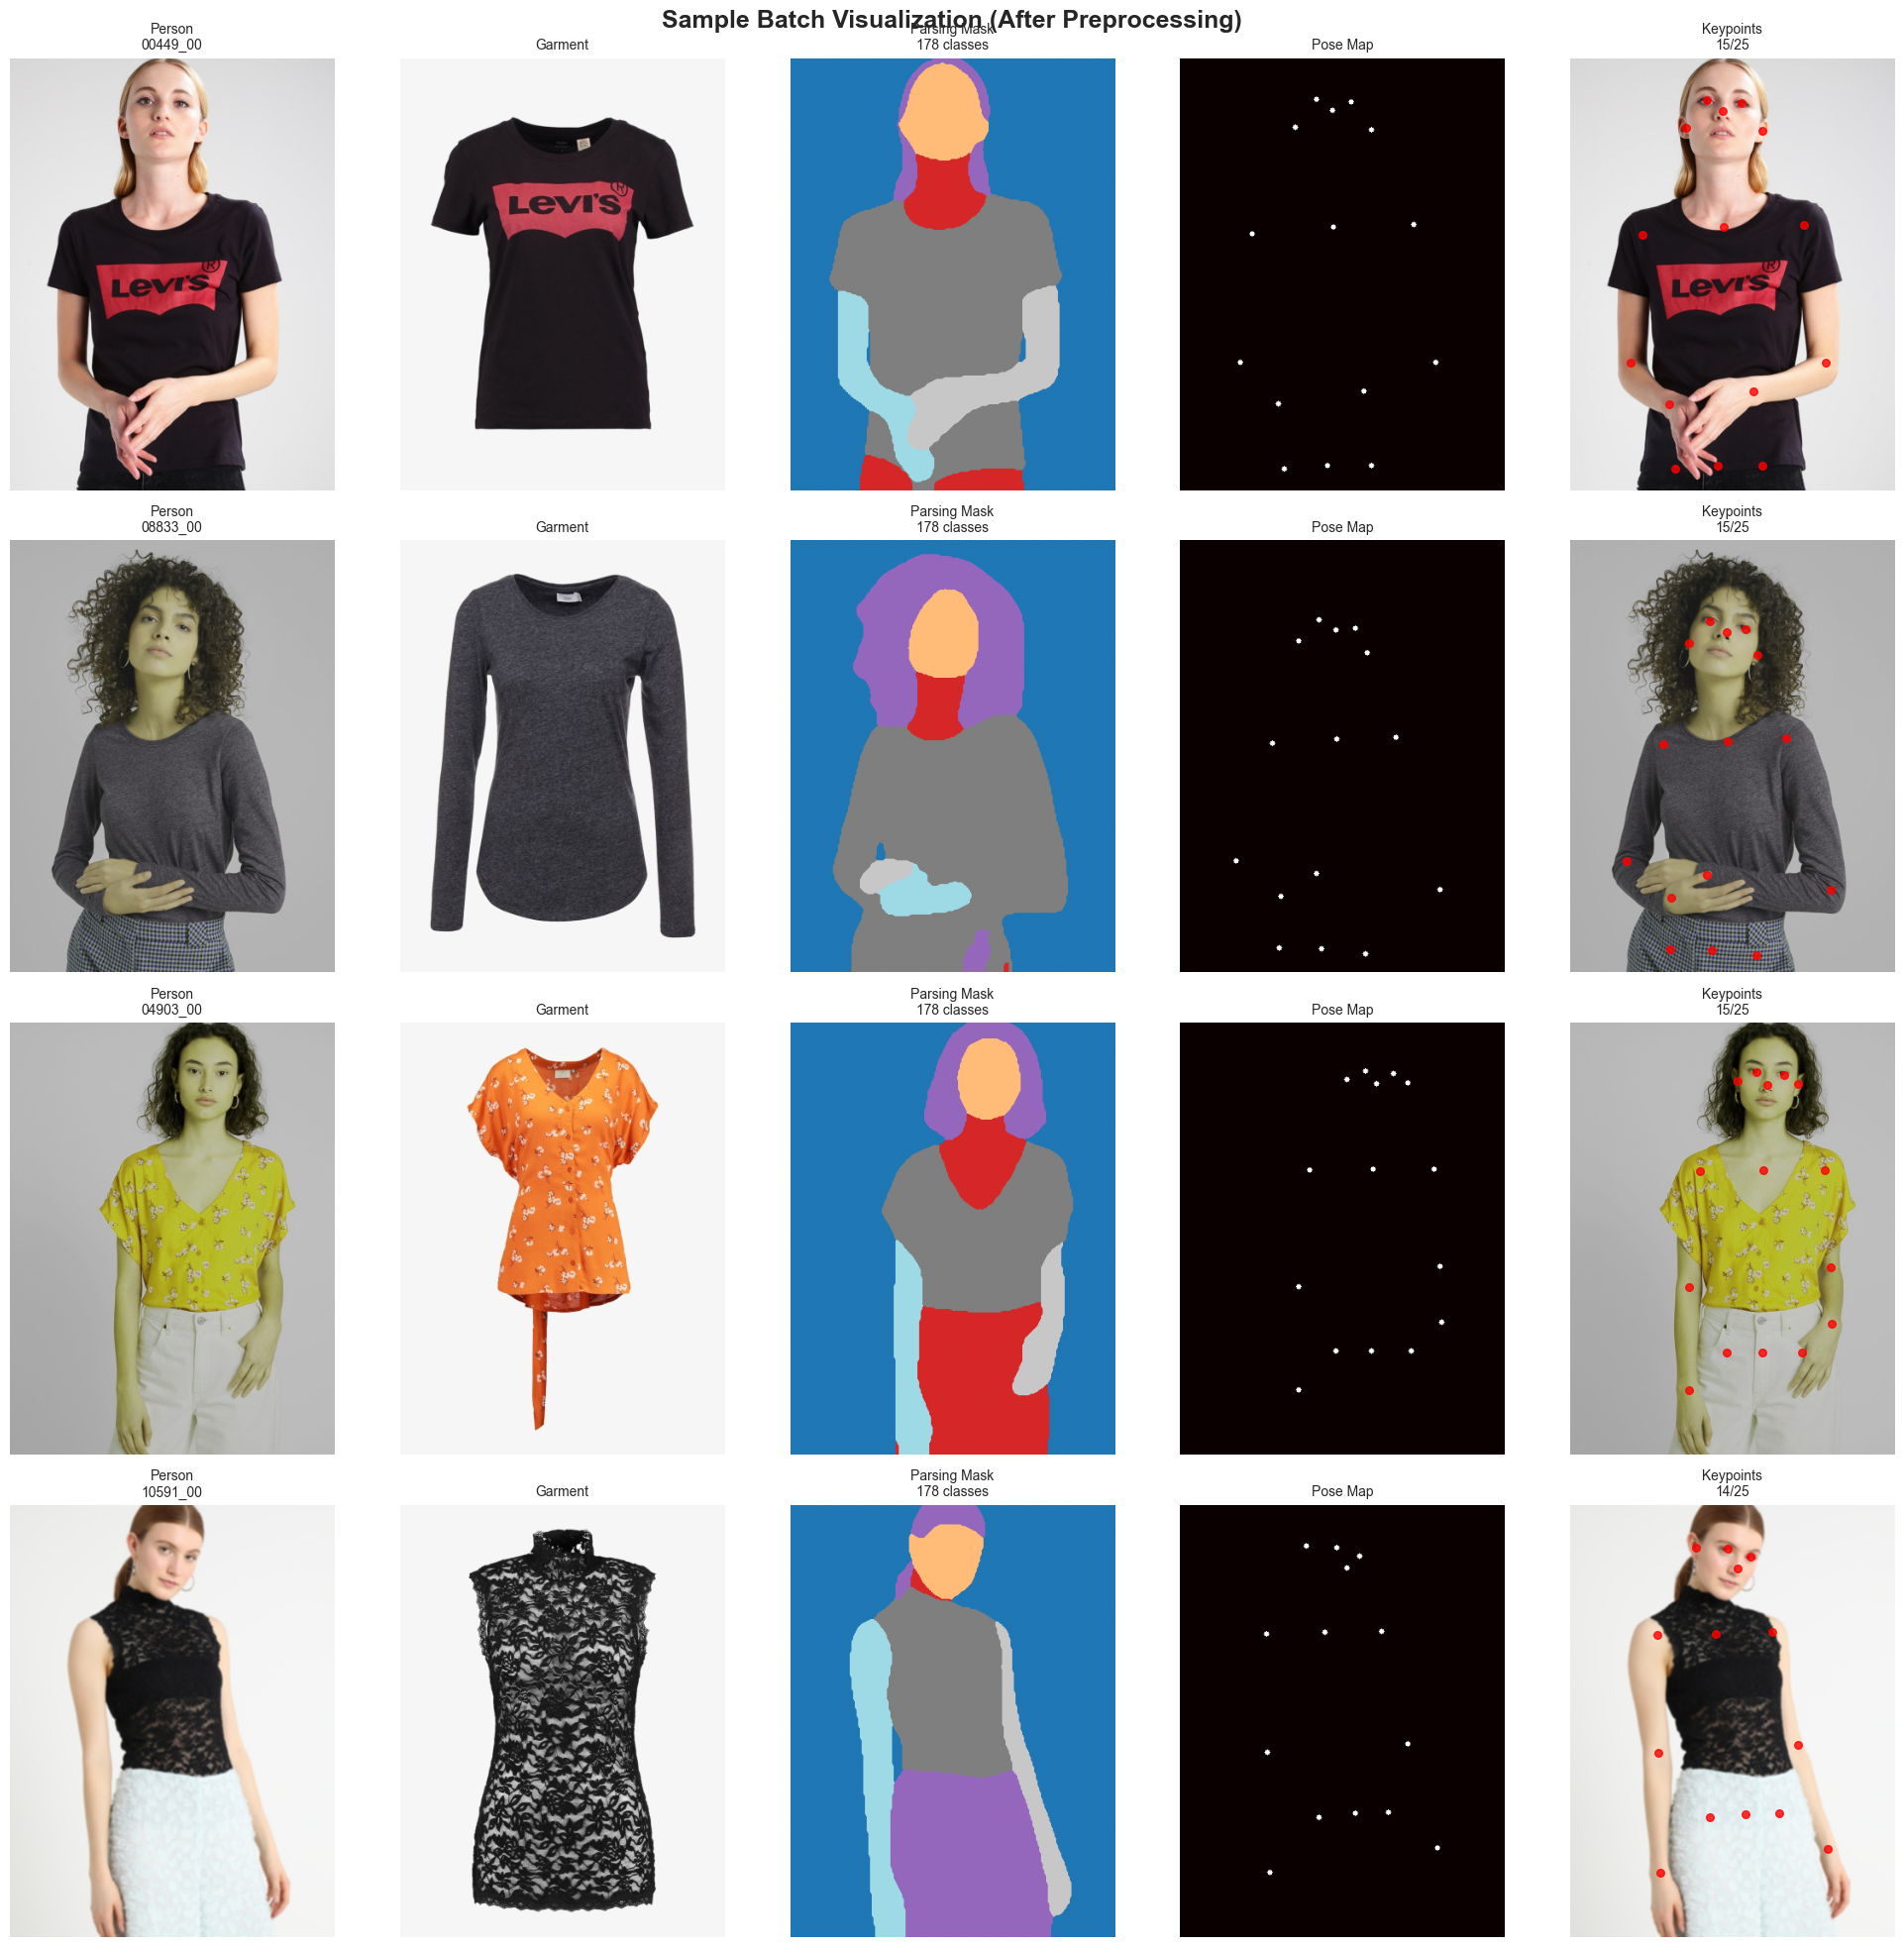

✅ Batch visualization complete!


In [10]:
def denormalize(tensor, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]):
    """Denormalize tensor for visualization."""
    tensor = tensor.clone()
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor.clamp(0, 1)

def tensor_to_image(tensor):
    """Convert tensor to numpy image."""
    if tensor.dim() == 4:
        tensor = tensor[0]  # Take first image from batch
    tensor = denormalize(tensor)
    return tensor.permute(1, 2, 0).cpu().numpy()

# Visualize first 4 samples from batch
n_samples = min(4, config['batch_size'])

fig, axes = plt.subplots(n_samples, 5, figsize=(20, 5 * n_samples))
fig.suptitle('Sample Batch Visualization (After Preprocessing)', fontsize=18, fontweight='bold')

for i in range(n_samples):
    # Person image
    person_img = denormalize(sample_batch['person_image'][i]).permute(1, 2, 0).cpu().numpy()
    axes[i, 0].imshow(person_img)
    axes[i, 0].set_title(f'Person\n{sample_batch["id"][i]}', fontsize=10)
    axes[i, 0].axis('off')
    
    # Cloth image
    cloth_img = denormalize(sample_batch['cloth_image'][i]).permute(1, 2, 0).cpu().numpy()
    axes[i, 1].imshow(cloth_img)
    axes[i, 1].set_title('Garment', fontsize=10)
    axes[i, 1].axis('off')
    
    # Parse mask
    parse_mask = sample_batch['parse_mask'][i].cpu().numpy()
    axes[i, 2].imshow(parse_mask, cmap='tab20')
    axes[i, 2].set_title(f'Parsing Mask\n{parse_mask.max()} classes', fontsize=10)
    axes[i, 2].axis('off')
    
    # Pose map
    pose_map = sample_batch['pose_map'][i].squeeze().cpu().numpy()
    axes[i, 3].imshow(pose_map, cmap='hot')
    axes[i, 3].set_title('Pose Map', fontsize=10)
    axes[i, 3].axis('off')
    
    # Pose keypoints overlay on person
    axes[i, 4].imshow(person_img)
    keypoints = sample_batch['pose_keypoints'][i].cpu().numpy()
    valid_kpts = keypoints[keypoints[:, 2] > 0.1]
    if len(valid_kpts) > 0:
        axes[i, 4].scatter(
            valid_kpts[:, 0], 
            valid_kpts[:, 1], 
            c='red', 
            s=30, 
            alpha=0.8
        )
    axes[i, 4].set_title(f'Keypoints\n{len(valid_kpts)}/25', fontsize=10)
    axes[i, 4].axis('off')

plt.tight_layout()
plt.show()

print("✅ Batch visualization complete!")

## 1️⃣1️⃣ Test Data Augmentation

🎨 Testing data augmentation variations...



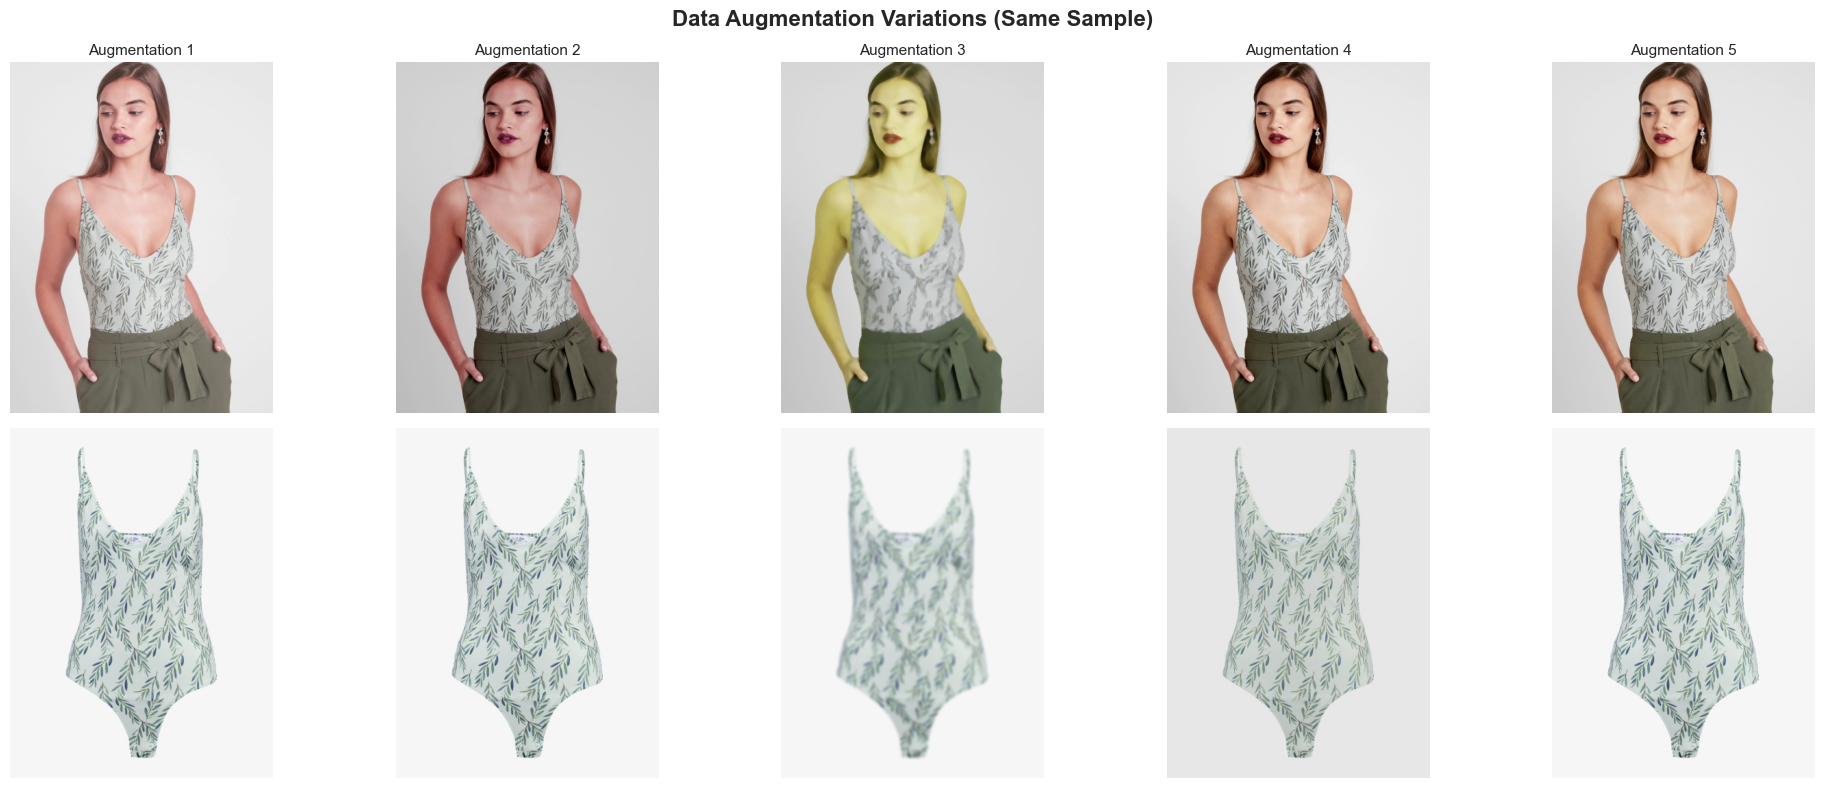

✅ Augmentation test complete!


In [11]:
# Load same sample multiple times to see augmentation variations
sample_idx = 0
n_augmentations = 5

print("🎨 Testing data augmentation variations...\n")

fig, axes = plt.subplots(2, n_augmentations, figsize=(20, 8))
fig.suptitle('Data Augmentation Variations (Same Sample)', fontsize=16, fontweight='bold')

for i in range(n_augmentations):
    # Get augmented sample
    sample = train_dataset[sample_idx]
    
    # Person image
    person_img = denormalize(sample['person_image']).permute(1, 2, 0).cpu().numpy()
    axes[0, i].imshow(person_img)
    axes[0, i].set_title(f'Augmentation {i+1}', fontsize=11)
    axes[0, i].axis('off')
    
    # Cloth image
    cloth_img = denormalize(sample['cloth_image']).permute(1, 2, 0).cpu().numpy()
    axes[1, i].imshow(cloth_img)
    axes[1, i].axis('off')

axes[0, 0].set_ylabel('Person', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Garment', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print("✅ Augmentation test complete!")

## 1️⃣2️⃣ Analyze Segmentation Mask Classes

In [12]:
# Sample masks to analyze classes
print("🔍 Analyzing segmentation mask classes...\n")

mask_classes = set()
sample_size = min(100, len(train_dataset))

for i in tqdm(range(sample_size), desc="Sampling masks"):
    sample = train_dataset[i]
    mask = sample['parse_mask'].cpu().numpy()
    mask_classes.update(np.unique(mask).tolist())

mask_classes = sorted(mask_classes)

print("="*70)
print("🎭 SEGMENTATION MASK ANALYSIS")
print("="*70)
print(f"\n📊 Found {len(mask_classes)} unique classes:")
print(f"   Classes: {mask_classes}")

# Common VITON-HD parsing classes:
# 0: Background
# 1: Hat
# 2: Hair
# 3: Glove
# 4: Sunglasses
# 5: Upper-clothes
# 6: Dress
# 7: Coat
# 8: Socks
# 9: Pants
# 10: Jumpsuits
# 11: Scarf
# 12: Skirt
# 13: Face
# 14: Left-arm
# 15: Right-arm
# 16: Left-leg
# 17: Right-leg
# 18: Left-shoe
# 19: Right-shoe

print("\n💡 Common class labels:")
class_names = {
    0: 'Background', 1: 'Hat', 2: 'Hair', 3: 'Glove', 4: 'Sunglasses',
    5: 'Upper-clothes', 6: 'Dress', 7: 'Coat', 8: 'Socks', 9: 'Pants',
    10: 'Jumpsuits', 11: 'Scarf', 12: 'Skirt', 13: 'Face',
    14: 'Left-arm', 15: 'Right-arm', 16: 'Left-leg', 17: 'Right-leg',
    18: 'Left-shoe', 19: 'Right-shoe'
}

for cls in mask_classes:
    if cls in class_names:
        print(f"   {cls:2d}: {class_names[cls]}")

print("\n" + "="*70)

🔍 Analyzing segmentation mask classes...



Sampling masks:   0%|          | 0/100 [00:00<?, ?it/s]

🎭 SEGMENTATION MASK ANALYSIS

📊 Found 12 unique classes:
   Classes: [0, 9, 28, 38, 55, 59, 75, 125, 139, 178, 193, 209]

💡 Common class labels:
    0: Background
    9: Pants



## 1️⃣3️⃣ Save Preprocessing Configuration

In [13]:
import yaml

# Save complete configuration
preprocessing_config = {
    'dataset': {
        'name': 'VITON-HD (Zalando HD Resized)',
        'root': str(dataset_root),
        'train_samples': len(train_df),
        'val_samples': len(val_df),
        'test_samples': len(test_df),
        'total_samples': len(train_df) + len(val_df) + len(test_df)
    },
    'preprocessing': {
        'image_size': config['image_size'],
        'normalization': {
            'mean': config['mean'],
            'std': config['std']
        },
        'augmentation': config['augmentation'],
        'augmentation_techniques': [
            'ColorJitter',
            'GaussianBlur',
            'MedianBlur'
        ] if config['augmentation'] else []
    },
    'dataloader': {
        'batch_size': config['batch_size'],
        'num_workers': config['num_workers'],
        'shuffle': config['shuffle'],
        'pin_memory': config['device'] == 'cuda'
    },
    'pose': {
        'num_keypoints': 25,
        'format': 'OpenPose',
        'keypoint_format': '[x, y, confidence]'
    },
    'segmentation': {
        'num_classes': len(mask_classes),
        'classes': mask_classes,
        'class_names': class_names
    }
}

# Save to YAML
config_path = output_dir / 'preprocessing_config.yaml'
with open(config_path, 'w') as f:
    yaml.dump(preprocessing_config, f, default_flow_style=False, sort_keys=False)

print("="*70)
print("💾 CONFIGURATION SAVED")
print("="*70)
print(f"\n📄 Saved to: {config_path}")
print("\n📋 Configuration:")
print(yaml.dump(preprocessing_config, default_flow_style=False, sort_keys=False))
print("="*70)

💾 CONFIGURATION SAVED

📄 Saved to: d:\Projects\AI-Virtual-TryOn\data\processed\preprocessing_config.yaml

📋 Configuration:
dataset:
  name: VITON-HD (Zalando HD Resized)
  root: d:\Projects\AI-Virtual-TryOn\data\zalando-hd-resized
  train_samples: 10482
  val_samples: 1165
  test_samples: 2032
  total_samples: 13679
preprocessing:
  image_size: !!python/tuple
  - 512
  - 384
  normalization:
    mean:
    - 0.5
    - 0.5
    - 0.5
    std:
    - 0.5
    - 0.5
    - 0.5
  augmentation: true
  augmentation_techniques:
  - ColorJitter
  - GaussianBlur
  - MedianBlur
dataloader:
  batch_size: 8
  num_workers: 4
  shuffle: true
  pin_memory: true
pose:
  num_keypoints: 25
  format: OpenPose
  keypoint_format: '[x, y, confidence]'
segmentation:
  num_classes: 12
  classes:
  - 0
  - 9
  - 28
  - 38
  - 55
  - 59
  - 75
  - 125
  - 139
  - 178
  - 193
  - 209
  class_names:
    0: Background
    1: Hat
    2: Hair
    3: Glove
    4: Sunglasses
    5: Upper-clothes
    6: Dress
    7: Coat
  

## 1️⃣4️⃣ Performance Test - Measure Loading Speed

In [ ]:
import time

print("⏱️ Testing data loading performance (Windows-compatible)...\n")

# Use the Windows-compatible loader from earlier (num_workers=0)
# Reuse test_loader_single if it exists, or create it
if 'test_loader_single' not in locals():
    test_loader_single = DataLoader(
        train_dataset,
        batch_size=config['batch_size'],
        shuffle=False,
        num_workers=0,
        pin_memory=True if config['device'] == 'cuda' else False
    )

# Test loading speed
n_batches = 10
times = []

print(f"📦 Testing with {n_batches} batches...\n")

for i, batch in enumerate(tqdm(test_loader_single, total=n_batches, desc="Performance test")):
    if i >= n_batches:
        break
    
    start = time.time()
    # Simulate model processing
    _ = batch['person_image'].to(config['device'])
    _ = batch['cloth_image'].to(config['device'])
    end = time.time()
    
    times.append(end - start)

avg_time = np.mean(times)
std_time = np.std(times)
samples_per_sec = config['batch_size'] / avg_time

print("\n" + "="*70)
print("⚡ PERFORMANCE METRICS")
print("="*70)
print(f"\n📊 Loading Speed:")
print(f"   Average batch time: {avg_time*1000:.2f} ± {std_time*1000:.2f} ms")
print(f"   Samples/second: {samples_per_sec:.2f}")
print(f"   Batches tested: {n_batches}")
print(f"   Batch size: {config['batch_size']}")
print(f"   Num workers: 0 (Windows-compatible)")

# Estimate epoch time
batches_per_epoch = len(train_dataset) // config['batch_size']
estimated_epoch_time = (batches_per_epoch * avg_time) / 60  # minutes

print(f"\n⏱️ Estimated Training Time:")
print(f"   Time per epoch: ~{estimated_epoch_time:.2f} minutes")
print(f"   Time for 100 epochs: ~{estimated_epoch_time * 100 / 60:.2f} hours")
print(f"\n💡 Note: Performance measured with num_workers=0")
print(f"   On Linux/Mac, num_workers>0 could be faster")
print("\n" + "="*70)

⏱️ Testing data loading performance...



## 1️⃣5️⃣ Summary and Next Steps

In [ ]:
print("="*70)
print("🎉 DATA PREPROCESSING PIPELINE COMPLETE!")
print("="*70)

print("\n✅ Completed Tasks:")
print("   1. ✓ Created dataset catalogs for train/val/test splits")
print("   2. ✓ Defined preprocessing transforms with augmentation")
print("   3. ✓ Implemented pose keypoints processing")
print("   4. ✓ Created PyTorch Dataset class (VITONDataset)")
print("   5. ✓ Set up DataLoaders for all splits")
print("   6. ✓ Validated pipeline with sample batches")
print("   7. ✓ Tested data augmentation")
print("   8. ✓ Analyzed segmentation masks")
print("   9. ✓ Saved preprocessing configuration")
print("   10. ✓ Measured loading performance")

print("\n📊 Pipeline Summary:")
print(f"   - Training samples: {len(train_dataset):,}")
print(f"   - Validation samples: {len(val_dataset):,}")
print(f"   - Test samples: {len(test_dataset):,}")
print(f"   - Image size: {config['image_size'][0]}×{config['image_size'][1]}")
print(f"   - Batch size: {config['batch_size']}")
print(f"   - Augmentation: {'Enabled' if config['augmentation'] else 'Disabled'}")
print(f"   - Device: {config['device']}")

print("\n📁 Generated Files:")
print(f"   - {output_dir / 'train_catalog.csv'}")
print(f"   - {output_dir / 'val_catalog.csv'}")
print(f"   - {output_dir / 'test_catalog.csv'}")
print(f"   - {output_dir / 'preprocessing_config.yaml'}")

print("\n🚀 Ready for Next Steps:")
print("   1. Proceed to notebook 04_human_parsing.ipynb")
print("   2. Implement human parsing models")
print("   3. Begin model architecture development")
print("   4. Start training pipeline")

print("\n💡 Tips:")
print("   - DataLoaders are ready to use in training scripts")
print("   - Adjust batch_size based on GPU memory")
print("   - Increase num_workers for faster loading (if CPU allows)")
print("   - Use config file for consistency across notebooks")

print("\n" + "="*70)
print("\n✅ PREPROCESSING PIPELINE READY FOR TRAINING!")
print("="*70)

---

## 📝 Notes

### Preprocessing Pipeline:

1. **Image Loading**: All images loaded using OpenCV and converted to RGB
2. **Resizing**: Images resized to target dimensions (default 512×384)
3. **Normalization**: Pixels normalized to [-1, 1] range using mean/std
4. **Augmentation**: Color jitter, blur applied during training
5. **Pose Processing**: OpenPose keypoints scaled to target size

### Data Augmentation:

Training augmentations:
- Color jitter (brightness, contrast, saturation, hue)
- Gaussian/Median blur
- Random variations to improve model robustness

Validation/Test: No augmentation, only resize and normalize

### Performance Considerations:

- **num_workers**: Increase for faster data loading (depends on CPU cores)
- **pin_memory**: Enabled for CUDA devices for faster transfer
- **batch_size**: Adjust based on GPU memory (8-16 typical for 12GB GPU)

### Troubleshooting:

**Issue**: Slow data loading
- **Solution**: Increase num_workers, reduce image size, or use SSD storage

**Issue**: Out of memory errors
- **Solution**: Reduce batch_size or image_size

**Issue**: Augmentation too aggressive
- **Solution**: Reduce augmentation parameters in transform pipeline

---

## 🔗 Useful Resources

- [PyTorch DataLoader Documentation](https://pytorch.org/docs/stable/data.html)
- [Albumentations Documentation](https://albumentations.ai/docs/)
- [OpenPose Keypoints Format](https://github.com/CMU-Perceptual-Computing-Lab/openpose/blob/master/doc/output.md)
- [VITON-HD Paper](https://arxiv.org/abs/2103.16874)

---

**Author**: Huzaifa Nasir  
**Date**: December 2025  
**Notebook**: 03_data_preprocessing.ipynb  
**Status**: ✅ Complete